In [1]:
import pandas as pd
import numpy as np

# import data
files = list(range(20,240,10))
files2 = list(range(250,490,20))
files = files + files2

filename1 = "new_york" + str(files[0]) + ".json"
df = pd.read_json(filename1, orient='records')

for i in range(1, len(files)):
    filename = "new_york" + str(files[i]) + ".json"
    json = pd.read_json(filename, orient='records')
    df = pd.concat([df, json])  
    
# create reviews per month column
df['reviews_per_month'] = df.reviews_count / (abs(df.months) + 1)

# drop irrelevant columns
cols = ['url', 'reviews_count', 'months', 'localized_city']
df = df.drop(columns=cols)

# drop NAs
df=df.dropna()

#df.head()

# Correct common abbreviations
df['cleaned_name'] = df['listing_name'].str.lower() \
.str.replace("/", " ") \
.str.replace(" w/ ", " with ") \
.str.replace(" br ", " bedroom ") \
.str.replace(" ba ", " bathroom ") \
.str.replace(" ac ", " air conditioning ") \
.str.replace(" dt ", " downtown ")

listing_names = list(df['cleaned_name'])

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# split into words
from nltk.tokenize import word_tokenize

cleaned_names = []
for name in listing_names:
    tokens = word_tokenize(name) # split into words
    words = [word for word in tokens if word.isalpha()] # remove punctuation or special characters
    words = [w for w in words if not w in stop_words] # remove stopwords
    cleaned_names.append(words)

# import word2vec model
import gensim.downloader as api
word_vectors = api.load("glove-wiki-gigaword-100")

# listing name embedding
name_vectors = []
word_vec_dict = {}
for name in cleaned_names:
    vector_list = [word_vectors[word] for word in name if word in word_vectors.vocab]
    if len(vector_list) > 1:
        name_vector = np.mean(vector_list, axis = 0)
        name_vectors.append(name_vector)
    if len(vector_list) == 1:
        name_vectors.append(vector_list[0])
    if len(vector_list) == 0:
        name_vectors.append(np.array([0] * 100))

# reduce name vectors to 15 dimensions     
from sklearn.decomposition import PCA

pca = PCA(n_components=15, random_state=10)

reduced_vecs = pca.fit_transform(name_vectors)

for i in range(15):
    colname = 'c_' + str(i)
    df[colname] = reduced_vecs[:,i]  

In [2]:
df.head()

,listing_id,price,bathrooms,bedrooms,is_superhost,lat,lng,listing_name,person_capacity,room_type_category,...,c_5,c_6,c_7,c_8,c_9,c_10,c_11,c_12,c_13,c_14
0,27678634,20,1.0,1.0,False,40.668720,-73.953430,Brooklyn Chill & Explore,2,private_room,...,-0.114761,-0.488204,0.567969,-0.038650,-0.655065,-0.280678,-0.556897,0.289369,0.020916,-0.163320
1,2062476,23,1.5,1.0,False,40.709460,-74.074320,A room in private house - 20-35 minutes from NYC,2,private_room,...,0.033249,-0.163629,0.512907,-0.508940,0.011784,-0.034007,-0.020552,0.165408,0.026181,0.367658
2,17157306,29,1.0,1.0,False,40.738020,-74.056990,Modern Room 20 Minutes to Times Square,2,private_room,...,1.061535,0.263956,-0.623987,-0.173793,0.013040,0.139797,-0.132379,0.008352,-0.564884,0.176254
3,401039,27,1.0,1.0,False,40.848860,-73.912230,Big and Comfy room near Yankee1,4,private_room,...,0.060883,-0.406233,0.136488,0.053615,-0.250396,-0.299606,-0.059454,-0.392709,0.115975,-0.065035
4,12798739,29,2.0,1.0,False,40.678509,-74.200249,Good Deal! Cozy room Near NYC/EWR,2,private_room,...,-0.126636,-0.517378,0.251064,-0.163608,0.063405,-0.204988,0.072095,0.161953,0.182331,0.278517


In [7]:
df.columns

Index(['listing_id', 'price', 'bathrooms', 'bedrooms', 'is_superhost', 'lat',
       'lng', 'listing_name', 'person_capacity', 'room_type_category',
       'can_instant_book', 'min_nights', 'max_nights', 'reviews_per_month',
       'cleaned_name', 'c_0', 'c_1', 'c_2', 'c_3', 'c_4', 'c_5', 'c_6', 'c_7',
       'c_8', 'c_9', 'c_10', 'c_11', 'c_12', 'c_13', 'c_14'],
      dtype='object')

In [3]:
# df.to_csv('NYC_airbnb.csv')

## Visualization of listing name embeddings

In [250]:
from sklearn.manifold import TSNE
# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

In [252]:
import seaborn as sns

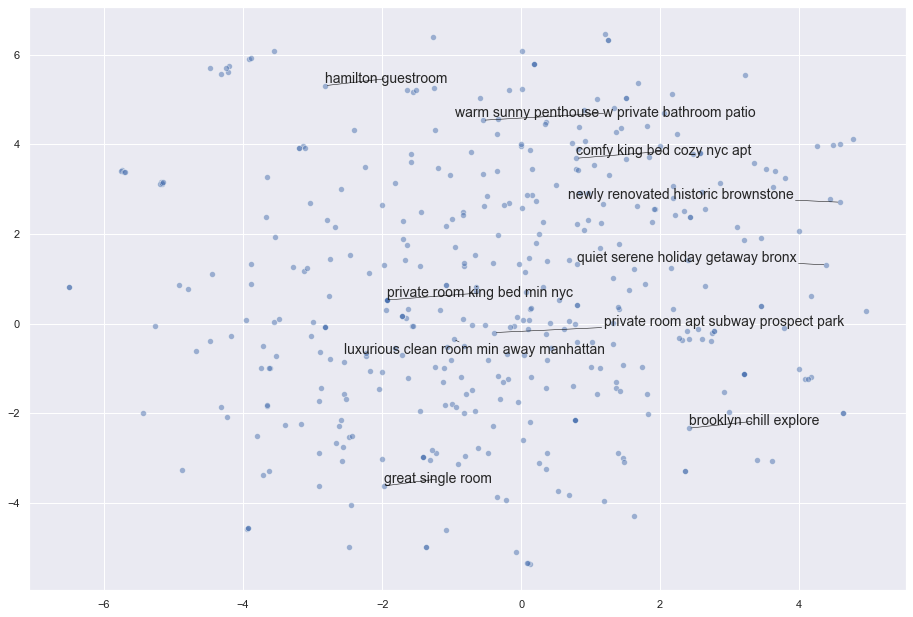

In [258]:
# Use a subset of 400 name embeddings
tsne_df = tsne.fit_transform(name_vectors[:400])

sns.set()
fig, ax = plt.subplots(figsize = (14, 10))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

from adjustText import adjust_text
texts = []
titles_to_plot = list(np.arange(0, 400, 40)) # sample 10 listing names to label

# Append words to list
for title in titles_to_plot:
    texts.append(plt.text(tsne_df[title, 0], tsne_df[title, 1], " ".join(cleaned_names[title]), fontsize = 14))
    
# Plot listing names
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

## Random Forest Model

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
from sklearn.metrics import mean_squared_error

In [10]:
# Build features
cols = ["listing_id", 'reviews_per_month', 'listing_name', 'cleaned_name']
features = df.drop(columns = cols)
features = pd.get_dummies(features)

# Target variable
labels = np.array(df['reviews_per_month'])

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = \
train_test_split(features, labels, test_size = 0.2, random_state = 42)

In [193]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid 
param_grid = {
    'bootstrap': [True],
    'max_depth': [20, 40, 60, None],
    'max_features': [5, 15, 20, 'auto'],
    'min_samples_split': [2, 4],
    'n_estimators': [20, 40, 60, 80]
}

rf = RandomForestRegressor()

# Use RMSE as criterion, 3-fold cross validation
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, scoring ="neg_mean_squared_error",
                           n_jobs = -1, cv = 3, verbose = 2)

# Fit the grid search 
grid_search.fit(train_features, train_labels)

print(grid_search.best_params_)
print(grid_search.best_score_)


Fitting 3 folds for each of 128 candidates, totalling 384 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   49.3s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 384 out of 384 | elapsed:  2.5min finished


{'bootstrap': True, 'max_depth': 20, 'max_features': 5, 'min_samples_split': 2, 'n_estimators': 80}
-16.10245811793667


In [23]:
# Build features column
cols = ["listing_id",'reviews_per_month', 'listing_name', 'cleaned_name']
features = df.drop(columns = cols)
features = pd.get_dummies(features)

# Labels are the values we want to predict
labels = np.array(df['reviews_per_month'])

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = \
train_test_split(features, labels, test_size = 0.2)


# Instantiate model with 100 decision trees
rf = RandomForestRegressor(n_estimators = 80,
 max_depth= 20, max_features=5, min_samples_split=2)

# Train the model on training data
rf = rf.fit(train_features, train_labels);

# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
rmse = sqrt(mean_squared_error(test_labels, predictions))
print("Test RMSE with best RF model:", round(rmse,3))

Test RMSE with best RF model: 3.85


In [264]:
# Save model
from joblib import dump, load

dump(rf, 'random_forest.joblib') 

#rf_best = load('random_forest.joblib') 


### Average baseline

In [12]:
# The average value as prediction
baseline_preds = np.mean(train_labels)
# Baseline error
rmse = sqrt(np.mean((test_labels-baseline_preds) ** 2))
print('Baseline RMSE:', round(rmse, 3))

Baseline RMSE: 4.296


In [30]:
# Build features
name_cols = []
for i in range(15):
    name_cols.append("c_" + str(i))

cols = ["listing_id", 'reviews_per_month', 'listing_name', 'cleaned_name'] + name_cols
features = df.drop(columns = cols)
features = pd.get_dummies(features)

# Target variable
labels = np.array(df['reviews_per_month'])

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = \
train_test_split(features, labels, test_size = 0.2, random_state = 42)


rf = RandomForestRegressor(max_depth=20, max_features=5, min_samples_split=2, n_estimators=80)
model = rf.fit(train_features, train_labels);
predictions = model.predict(test_features)
# Calculate the absolute errors
rmse = sqrt(mean_squared_error(test_labels, predictions))
print("RMSE (without name vectors):", round(rmse,3))

RMSE (without name vectors): 4.185


#### Plot variable importance

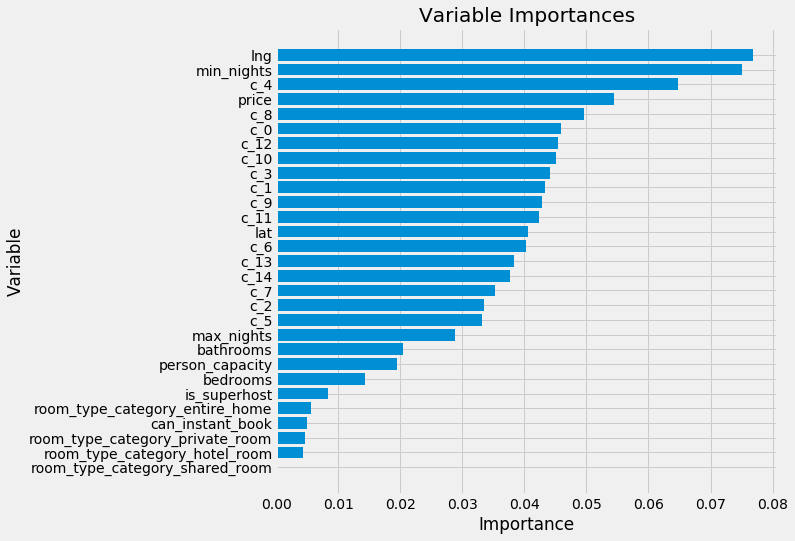

In [233]:

import matplotlib.pyplot as plt
%matplotlib inline

# Set the style
plt.rcParams["figure.figsize"] = (8,8)
plt.style.use('fivethirtyeight')

feature_list = list(features.columns)

importances = list(best_grid.feature_importances_)

dictionary = dict(zip(feature_list, importances))

sorted_dict = dict(sorted(dictionary.items(), key=lambda kv: kv[1]))

y_values = list(range(len(importances)))

plt.barh(y_values, sorted_dict.values())

plt.yticks(y_values, sorted_dict.keys(), rotation='horizontal')

plt.ylabel('Variable'); plt.xlabel('Importance'); plt.title('Variable Importances');

### Save grid search results

In [205]:
results = grid_search.cv_results_

In [211]:
results.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_bootstrap', 'param_max_depth', 'param_max_features', 'param_min_samples_split', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [200]:
params = results['params']

params_df = pd.DataFrame(params)

params_df['rmse'] = np.sqrt(abs(results['mean_test_score']))

params_df['mean_fit_time'] = results['mean_fit_time']

params_df.head()

In [215]:
params_df.to_csv("param.csv")